# Deep learning assessment

The following notebook develops and compares 2 CNN models which are able to clasfiffy images with a cell nuclei in the centre of the image into 4 categories:
 
1. Normal epithelial cell nuclei with label 0.
2. Cancer epithelial cell nuclei with label 1.
3. Muscle cell nuclei with label 2.
4. Immune leukocyte cell nuclei with label 3.

## Import dependecies


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

!pip install captum
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from skimage import io, transform
import datetime
import collections
from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


from torch.optim import lr_scheduler
import torchvision
from torchvision import models, datasets

from PIL import Image

import copy
import time
import os
import shutil

# For ray-tuning
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from functools import partial
from torch.utils.data import random_split

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

# Input data files are available in the read-only "../input/" director

# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)
        
        

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.7 MB/s eta 0:00:00


## Set the seed

The seed is set for torch, numpy and python so that it is fully repeatable.

In [2]:
np.random.seed(seed=0)
torch.manual_seed(0)
random.seed(0)

path_to_dir = "/kaggle/input/deep-learning-for-msc-2022-23/train.csv"

## Inspect the data

The data provided consists of a set of 100x100 pixel images with coresponding csv files provided the labels. There are 7560 training samples and 5041 testing samples. A pandas dataframe is created with the fields `'Filename'` and `'Label'`.

In [3]:
train_data = pd.read_csv(path_to_dir)
print(f'Data contains: {len(train_data)} samples')
print(train_data.head())

Data contains: 7560 samples
  Filename  Label
0    1.png      0
1    2.png      0
2    3.png      0
3    4.png      0
4    5.png      0


## Display image

A helper function is made to display images with the coresponding label.

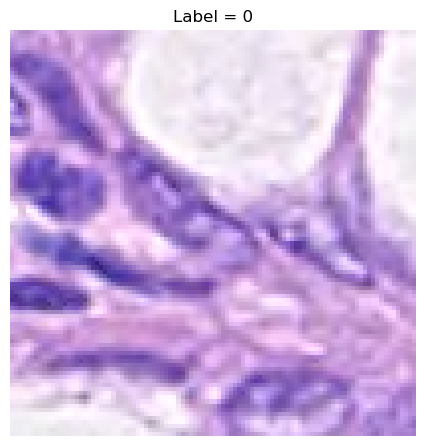

In [4]:
def show_Label(image,Label):
    """Show image with Label"""
    plt.imshow(image)
    plt.title(f'Label = {Label}')
    plt.tight_layout()
    plt.axis('off')
    plt.pause(0.001)  # pause a bit so that plots are updated

img_name = train_data['Filename'].iloc[0]
Label = train_data['Label'].iloc[0]

plt.figure()
show_Label(io.imread(os.path.join('/kaggle/input/deep-learning-for-msc-2022-23/train', img_name)), Label)
plt.show()

## Dataset class

A custom dataset class is created which inherits from the ``torch.utils.data.Dataset`` class and overides the following methods:

-  ``__len__`` so that ``len(dataset)`` returns the size of the dataset.
-  ``__getitem__`` to support the indexing such that ``dataset[i]`` can be used to get $i^{th}$ sample.

The csv is read in the ``__init__`` but leaves reading of images to
``__getitem__`` which is memory efficient as not all images are stored in the memory but rather read as required.

The sample of the dataset will be a dict ``{'image': image, 'Label': Label}``


The dataset will also take an optional argument ``transform`` so that any required processing can be
applied on the sample as well as an input `ids` which is a list of ids that is used to split the test and train datasets.

In [5]:
class labeledDataset(Dataset):
    """Face Label dataset."""

    def __init__(self, csv_file, root_dir,ids, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        df = pd.read_csv(csv_file)
        self.imgs = df.iloc[ids,:]
        
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.imgs['Filename'].iloc[idx])

        image = Image.open(img_name)
        Label = self.imgs['Label'].iloc[idx]
        
        if self.transform:
            image = self.transform(image)
            Label = torch.tensor(Label)
        
        sample = {'image': image, 'Label': Label}

        # if self.transform:
        #     sample = self.transform(sample)

        return sample

## Constructing datasets
The dataset is split into a training and testing dataset at a ratio of 80:20 As is standard in deep learning.

**Data augmentation** is used in the training set to provide more variation within the training set. Training set is resized and croped at random as well as random horizontal flips. This is then converted to a tensor and normalised. The testing set is kept more constant with a constant resize and centercrop. It is also converted to a tensor and normalised same as the training set.

The `torch.utils.data.DataLoader` is used to constuct the dataloders using the datasets.

In [6]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

## Generate IDs for train-test split
train_ids, test_ids = train_test_split(np.arange(0,7560),test_size=0.2,train_size=0.8)

ids = {}
ids['train'] = train_ids
ids['val'] = test_ids

image_datasets = {x: labeledDataset(csv_file=r'/kaggle/input/deep-learning-for-msc-2022-23/train.csv',
                                    root_dir=r'/kaggle/input/deep-learning-for-msc-2022-23/train',
                                    ids = ids[x],transform=data_transforms[x])
                                for x in ['train', 'val']}


dataloaders = {x: DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

# Define possible labels
class_names = [0,1,2,3]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Batch display

A helper function is constructed that shows what a batch of data fed into the model looks like.

0 torch.Size([4, 3, 224, 224]) torch.Size([4])
1 torch.Size([4, 3, 224, 224]) torch.Size([4])
2 torch.Size([4, 3, 224, 224]) torch.Size([4])
3 torch.Size([4, 3, 224, 224]) torch.Size([4])


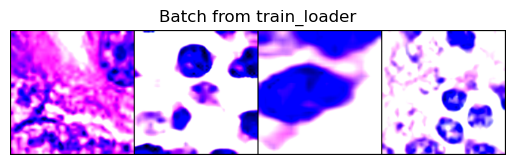

In [7]:
# Helper function to show a batch
def show_batch(sample_batched):
    """Show image with Label for a batch of samples."""
    images_batch, Label_batch = \
            sample_batched['image'], sample_batched['Label']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.title('Batch from train_loader')
    
if __name__ == '__main__':
    for i_batch, sample_batched in enumerate(dataloaders['train']):
        print(i_batch, sample_batched['image'].size(),
            sample_batched['Label'].size())

        # observe 4th batch and stop.
        if i_batch == 3:
            plt.figure()
            show_batch(sample_batched)
            plt.axis('off')
            plt.ioff()
            plt.show()
            break

## Build the networks

2 models are constructed:

- A CNN with random intial parameters
- A pretrained CNN with resnet18 weights

For the custom CNN, 2 convolutional layers are used, each are maxpooled after paassing through a Rectified Linear Unit. This is then flattened. Since the input images(after tranformation) have a size of 224x224, the last convolutional has an output of 30 and there are 2 Max pooling layers the linear layer has an input of 224x224x30/(4x4) = 94080. This is the passed to another 2 other linear layers to map the output to 4 ,the number of classes.


For the pretrained net, the model is loaded in and the output linear layer is modified to have 4 outputs.

Both models are added to the GPU for training.

## Function to visualise confusion matrix

In [8]:
## Custom model
class Net(nn.Module):
    def __init__(self, l1=120, l2=60):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3,20,3,padding=1)
        self.conv2 = nn.Conv2d(20, 30, 3,padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(94080, l1)
        self.fc2 = nn.Linear(l1, l2)
        self.fc3 = nn.Linear(l2, 4)
        self.flat = nn.Flatten()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.flat(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
      
model = Net()
model = model.to(device)

## Model initialised with resnet weights
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 4)

model_ft = model_ft.to(device)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

## Training & Testing function
A training loop is made which outputs the losses, accuracies used for later plotting and the trained model. This also contains the testing loop. 

In [9]:

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    ## training, test losses and acuracy are stored in a list for later plotting
    losses = {'train':  [], 'val': []}
    accs = {'train':  [], 'val': []}
    
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for item in dataloaders[phase]:
                inputs = item['image']
                labels = item['Label']
                
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            losses[phase].append(epoch_loss)
            accs[phase].append(epoch_acc.cpu())
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())


    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return losses,accs, model

## Confusion Matrix
A function is designed to visulaise the predected and real labels to help understand what the model is struggling with

In [10]:
def confusion_matrix(model,num_images = 4):

    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, item in enumerate(dataloaders['val']):
            inputs = item['image']
            labels = item['Label']
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]} label:{labels[j]}')
                plt.imshow(inputs.cpu().data[j].transpose( 2, 0))
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return plt.show()

        model.train(mode=was_training)


### Set training parameters
The training parameters are set. Cross entropy loss is used as it is ideal for classification tasks as it measures the difference between the predicted probability distribution and the true probability distribution of the classes.

The models are then trained with 30 epochs, as is seen later loss begin to converge to a minimum around this number of epochs.

In [11]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001,momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001,momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_ft = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### Train the models!

In [12]:
losses_ft, accs_ft, model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler_ft,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.8189 Acc: 0.7082
val Loss: 0.4345 Acc: 0.8300
Epoch 1/24
----------
train Loss: 0.6781 Acc: 0.7579
val Loss: 0.3006 Acc: 0.8862
Epoch 2/24
----------
train Loss: 0.6181 Acc: 0.7882
val Loss: 0.2391 Acc: 0.9180
Epoch 3/24
----------
train Loss: 0.5601 Acc: 0.8047
val Loss: 0.3673 Acc: 0.8697
Epoch 4/24
----------
train Loss: 0.5227 Acc: 0.8171
val Loss: 0.3183 Acc: 0.8690
Epoch 5/24
----------
train Loss: 0.4555 Acc: 0.8414
val Loss: 0.1709 Acc: 0.9458
Epoch 6/24
----------
train Loss: 0.4663 Acc: 0.8352
val Loss: 0.2480 Acc: 0.9034
Epoch 7/24
----------
train Loss: 0.3058 Acc: 0.8957
val Loss: 0.1389 Acc: 0.9511
Epoch 8/24
----------
train Loss: 0.3020 Acc: 0.8962
val Loss: 0.1322 Acc: 0.9517
Epoch 9/24
----------
train Loss: 0.3043 Acc: 0.8970
val Loss: 0.1259 Acc: 0.9517
Epoch 10/24
----------
train Loss: 0.2971 Acc: 0.8970
val Loss: 0.1226 Acc: 0.9603
Epoch 11/24
----------
train Loss: 0.2825 Acc: 0.9038
val Loss: 0.1158 Acc: 0.9570
Epoch 12/24
--

In [13]:
losses, accs, model = train_model(model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=30)

Epoch 0/29
----------
train Loss: 0.8323 Acc: 0.6687
val Loss: 0.6795 Acc: 0.7540
Epoch 1/29
----------
train Loss: 0.6500 Acc: 0.7574
val Loss: 0.5218 Acc: 0.7877
Epoch 2/29
----------
train Loss: 0.6255 Acc: 0.7627
val Loss: 0.4979 Acc: 0.8069
Epoch 3/29
----------
train Loss: 0.6030 Acc: 0.7750
val Loss: 0.4858 Acc: 0.8280
Epoch 4/29
----------
train Loss: 0.5812 Acc: 0.7786
val Loss: 0.5055 Acc: 0.8108
Epoch 5/29
----------
train Loss: 0.5582 Acc: 0.7910
val Loss: 0.4512 Acc: 0.8380
Epoch 6/29
----------
train Loss: 0.5397 Acc: 0.7981
val Loss: 0.5629 Acc: 0.7917
Epoch 7/29
----------
train Loss: 0.4622 Acc: 0.8228
val Loss: 0.3687 Acc: 0.8591
Epoch 8/29
----------
train Loss: 0.4409 Acc: 0.8342
val Loss: 0.3460 Acc: 0.8684
Epoch 9/29
----------
train Loss: 0.4371 Acc: 0.8347
val Loss: 0.3597 Acc: 0.8684
Epoch 10/29
----------
train Loss: 0.4255 Acc: 0.8363
val Loss: 0.3447 Acc: 0.8664
Epoch 11/29
----------
train Loss: 0.4281 Acc: 0.8345
val Loss: 0.3494 Acc: 0.8638
Epoch 12/29
--

## lot accuracy and loss
The Loss and accuracy are plotted for both models. As can be seen the finetuned model loss converges much lower than the CNN made and accuracy yields simmilar results where it converges at a much higher number. 

What is also found is that the custom CNN has a larger discrepency wetween the training acuracy and testing accuracy which is a sign that it could be overfitting the data.

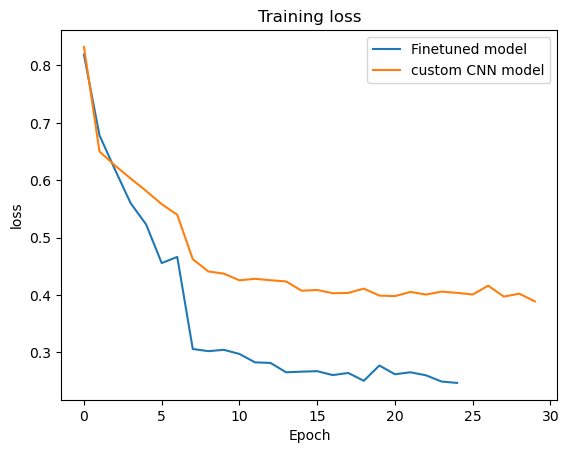

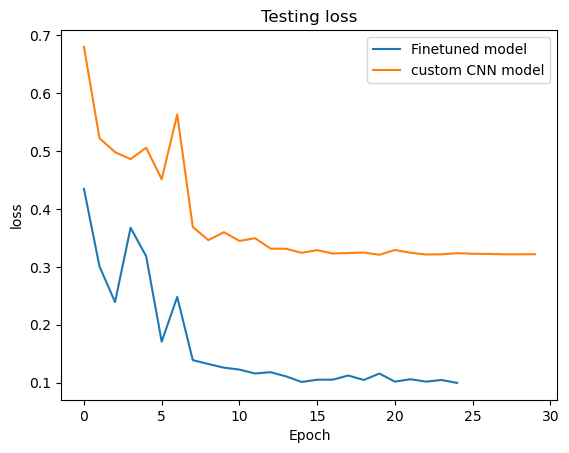

{'train': [0.818903937159727, 0.6781470416404465, 0.6181276311103757, 0.5601151776863459, 0.5227303547952842, 0.45553301115521533, 0.4662750927352891, 0.30575585010028494, 0.3019996288773929, 0.3043185624268729, 0.2971203828377713, 0.2825047051758572, 0.28146041733940824, 0.2651676068683931, 0.26625240901093955, 0.267127406353158, 0.2602887141558948, 0.26395949016684894, 0.25035127206913704, 0.2769766852115503, 0.26174925111167047, 0.2651334950012382, 0.25989917325898115, 0.2490150143850346, 0.24662858627277068], 'val': [0.43448009078234445, 0.30060177418435974, 0.23913339036678533, 0.36727970054314013, 0.31827682020641906, 0.17085139905552196, 0.24801817484860303, 0.13890583642613527, 0.13224916612994597, 0.12592757341232355, 0.12260891211517254, 0.11582638311542315, 0.11811890279431951, 0.11088392445880725, 0.10124831794910182, 0.10508447765483103, 0.10520419221471197, 0.11237726181594004, 0.10467197806301845, 0.11575633487537892, 0.10179195234038628, 0.10598872451770129, 0.101789193

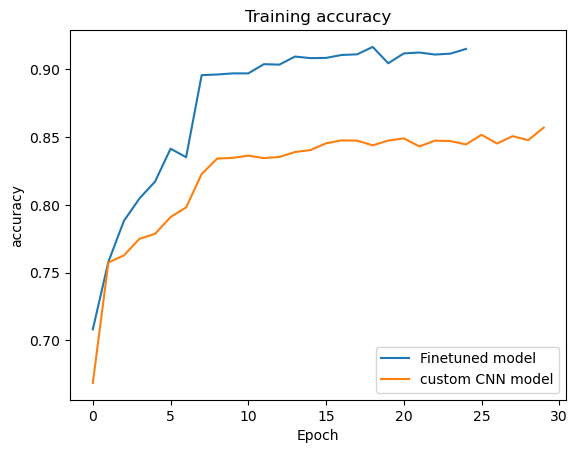

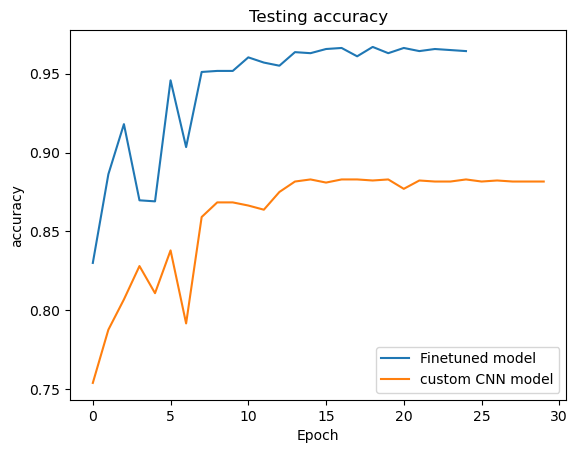

{'train': [tensor(0.7082, dtype=torch.float64), tensor(0.7579, dtype=torch.float64), tensor(0.7882, dtype=torch.float64), tensor(0.8047, dtype=torch.float64), tensor(0.8171, dtype=torch.float64), tensor(0.8414, dtype=torch.float64), tensor(0.8352, dtype=torch.float64), tensor(0.8957, dtype=torch.float64), tensor(0.8962, dtype=torch.float64), tensor(0.8970, dtype=torch.float64), tensor(0.8970, dtype=torch.float64), tensor(0.9038, dtype=torch.float64), tensor(0.9034, dtype=torch.float64), tensor(0.9094, dtype=torch.float64), tensor(0.9082, dtype=torch.float64), tensor(0.9084, dtype=torch.float64), tensor(0.9105, dtype=torch.float64), tensor(0.9110, dtype=torch.float64), tensor(0.9165, dtype=torch.float64), tensor(0.9044, dtype=torch.float64), tensor(0.9117, dtype=torch.float64), tensor(0.9124, dtype=torch.float64), tensor(0.9109, dtype=torch.float64), tensor(0.9115, dtype=torch.float64), tensor(0.9150, dtype=torch.float64)], 'val': [tensor(0.8300, dtype=torch.float64), tensor(0.8862, dty

In [14]:
plt.figure(1)
plt.title(f'Training loss')
plt.plot(losses_ft['train'],label='Finetuned model')
plt.plot(losses['train'],label= 'custom CNN model')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.show()

plt.figure(2)
plt.title(f'Testing loss')
plt.plot(losses_ft['val'],label='Finetuned model')
plt.plot(losses['val'],label= 'custom CNN model')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.show()
print(losses_ft)

plt.figure(3)
plt.title(f'Training accuracy')
plt.plot(accs_ft['train'],label='Finetuned model')
plt.plot(accs['train'],label= 'custom CNN model')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.show()

plt.figure(4)
plt.title(f'Testing accuracy')
plt.plot(accs_ft['val'],label='Finetuned model')
plt.plot(accs['val'],label= 'custom CNN model')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.show()

print(accs_ft)

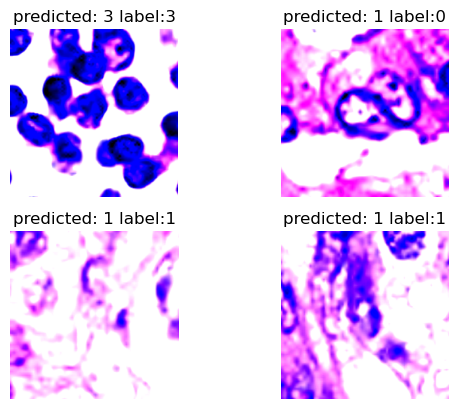

In [15]:
confusion_matrix(model)

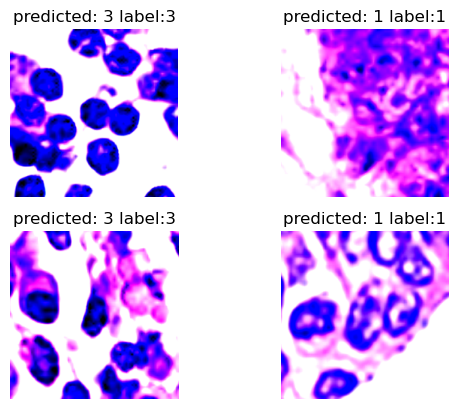

In [16]:
confusion_matrix(model_ft)

## Using Captum

Using captum the model can be interpreted.

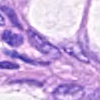

In [17]:
df = example_data = pd.read_csv(path_to_dir)

idx_to_labels = df['Label']

img = Image.open(r'/kaggle/input/deep-learning-for-msc-2022-23/train/1.png')

img

In [18]:
transform = transforms.Compose([
 transforms.Resize(256),
 transforms.CenterCrop(224),
 transforms.ToTensor()
])

transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
)

transformed_img = transform(img)

input = transform_normalize(transformed_img)

input = input.unsqueeze(0)


In [19]:
model_ft = model_ft.cpu()
output = model_ft(input)

output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

pred_label_idx.squeeze_()

predicted_label = idx_to_labels[pred_label_idx.item()]
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')


Predicted: 0 ( 0.8442561626434326 )


## Gradient-based attribution
Gradient based atribution looks at the integral of gradients with respect to innputs along a pathfrom the baseline to input. This then shows which inputs contribute the most to the output class.

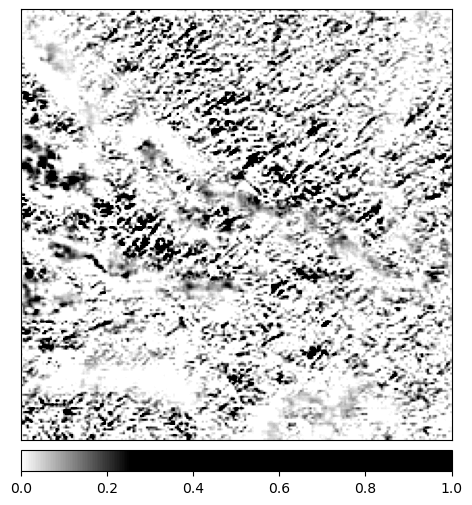

In [20]:
integrated_gradients = IntegratedGradients(model_ft.cpu())
attributions_ig = integrated_gradients.attribute(input, target=pred_label_idx, n_steps=200)

default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)


In [21]:
## This cell works on my local computer but crashes the kaggle notebook as it alocates too much memory so I have comented it out to avoid it crashing

# noise_tunnel = NoiseTunnel(integrated_gradients)

# attributions_ig_nt = noise_tunnel.attribute(input, nt_samples=10, nt_type='smoothgrad_sq', target=pred_label_idx)
# _ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
#                                       np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
#                                       ["original_image", "heat_map"],
#                                       ["all", "positive"],
#                                       cmap=default_cmap,
#                                       show_colorbar=True)

## Gradient SHAP 

This adds random noise multiple times to each input sample, selsts a random point along the pathe from input to baselin and computes the gradient of outputs with respect to those selected points.


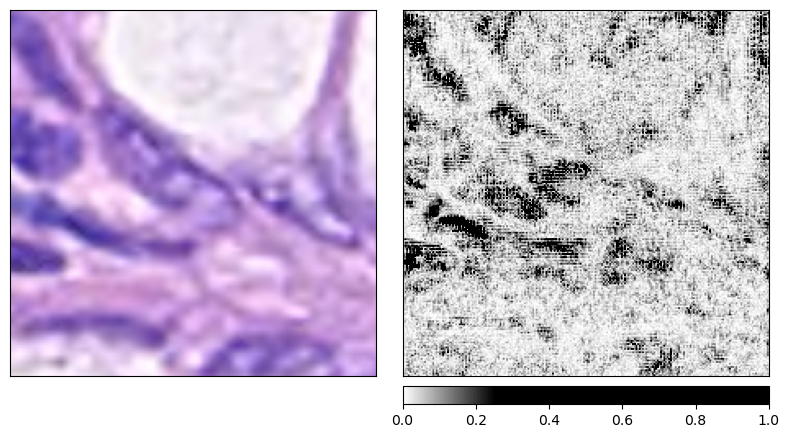

In [22]:
model.cpu()

gradient_shap = GradientShap(model)

# Defining baseline distribution of images
rand_img_dist = torch.cat([input * 0, input * 1])

attributions_gs = gradient_shap.attribute(input,
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=default_cmap,
                                      show_colorbar=True)


## Occlusion

This algorithm replaces each contiguous rectangular region with a baseline and computes the difference in output. This is ideal in the case of images as pixels have a large impact on the output of the model

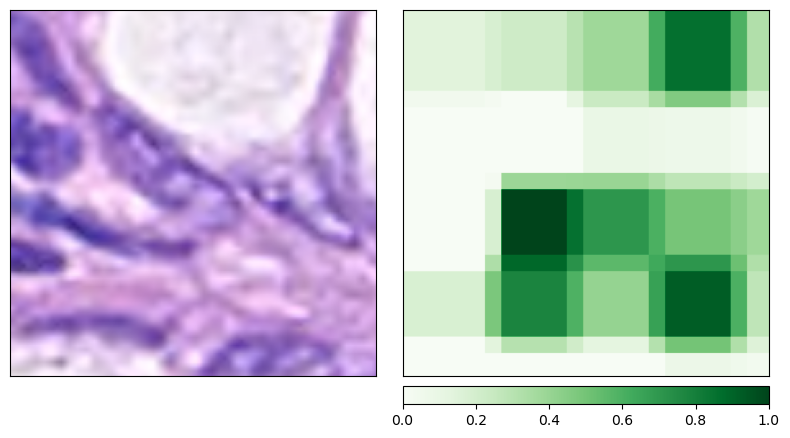

In [23]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(input,
                                       strides = (3, 50, 50),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,60, 60),
                                       baselines=0)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )

The submission folder is then made using the most successful model

In [24]:
transformation = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

model_ft.to(device)

path_to_example_csv = '/kaggle/input/deep-learning-for-msc-2022-23/example.csv'
path_to_example_dir = '/kaggle/input/deep-learning-for-msc-2022-23/test'

val_dataset  = labeledDataset(csv_file=path_to_example_csv,
                                           root_dir=path_to_example_dir,
                                           ids = np.arange(0,5041),transform=transformation )

val_loader = DataLoader(val_dataset, batch_size=1,
                        shuffle=False, num_workers=0)


filenames = pd.read_csv(path_to_example_csv)

filenames = filenames['Filename']

names = []
preds = []

for idx, item in enumerate(val_loader):
    img_name = filenames[idx]
    imgs=item['image']
    labels = item['Label']
    imgs = imgs.to(device)
    output = model_ft(imgs)
    pred = output.argmax(dim=1, keepdim=True)
    pred = pred.cpu()
    preds.append(pred.numpy()[0][0])
    names.append(img_name)
    


# print(f'The predicted label is{preds.numpy()[0][0]}')

data = {'Filename': names, 'Label': preds}

df = pd.DataFrame(data)

df.to_csv('submission.csv',index=False)